# Ordered Logistic Regression:

### using OrderedLogistic Distribution Probability Function

In [1]:
import arviz as az
import numpy as np
import jax
try:
    import jax.numpy as jnp
except:
    print('Using numpy instead')
    jnp = np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpyro
import numpyro.distributions as dist
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
from numpyro import handlers
from numpyro.infer.reparam import TransformReparam

In [2]:
# Visualization styling methods

numpyro.set_host_device_count(4)
az.style.use("arviz-darkgrid")


In [ ]:
# Example dataset

example_filepath = "kaggle_survey_2020_responses.csv"

In [3]:
df = (
    pd.read_csv(example_filepath, header=[1])
    .iloc[:, [4, 7, 8]]
    .copy()
)

df.columns = ["education", "python", "R"]
df["python"] = ~df["python"].isna()
df["R"] = ~df["R"].isna()
df = df[
    df["education"].isin(
        [
            "Doctoral degree",
            "Master’s degree",
            "Bachelor’s degree",
            "No formal education past high school",
        ]
    )
].reset_index(drop=True)
df["education"] = df["education"].replace(
                    "No formal education past high school", "High school"
                ).reset_index(drop=True)

np.random.seed(2)

# Sampling a subset of the dataset
    # df = df.sample(n=10_000)

In [23]:
print('N° samples', len(df))

df

N° samples 17379


,education,python,R
0,Doctoral degree,True,True
1,Master’s degree,True,True
2,Bachelor’s degree,False,False
3,Master’s degree,True,False
4,Master’s degree,True,False
...,...,...,...
17374,Master’s degree,False,False
17375,Master’s degree,True,False
17376,Master’s degree,True,False
17377,Bachelor’s degree,True,False


In [5]:
education_to_index = {
    "High school": 0,
    "Bachelor’s degree": 1,
    "Master’s degree": 2,
    "Doctoral degree": 3,
}

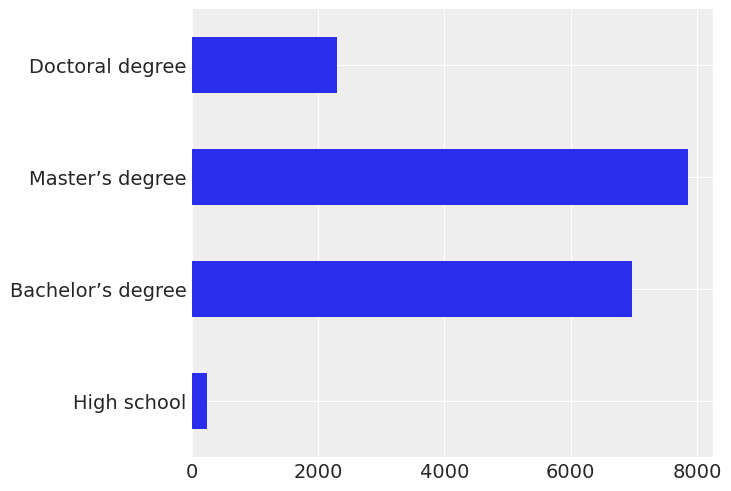

In [6]:
df["education"].value_counts().reindex(education_to_index).plot.barh();

## Categorical Distribution

In [7]:
# suppose classes follow the respective order: [0, 1, 2]
# each class has a picking chance
picking_chances = [.3, .5, .2]

Categorical_Distribution_sampler = dist.Categorical(probs=jnp.array(picking_chances))

N_samples = 100

Categorical_Distribution_sampler.sample(jax.random.PRNGKey(0),
                                 sample_shape=(N_samples,)
                                )

Categorical_Distribution = (pd.Series(Categorical_Distribution_sampler)
                           .value_counts(normalize=True)
                           .sort_index()
                           )

# Expected probabilities from random sampling with reposition given a N_sampling effort of 100:

Categorical_Distribution

# as N_sampling converges to infinity, the initial probabilities will converge to the initial picking chances

<numpyro.distributions.discrete.CategoricalProbs object at 0x7f17c4adde20>    1.0
dtype: float64

## Back to our problem

Should be try predicting these probabilities directly?
Maybe not, maybe we need some additional structure to capture the ordering among them.

Define

    class 0: high school
    class 1: Bachelor's degree
    class 2: Master's degree
    class 3: Doctoral degree

We have the probabilities of each class

    p_0: probability of class 0
    p_1: probability of class 1
    p_2: probability of class 2
    p_3: probability of class 3
    
Take cumulative probabilities:

    q_0: probability of class 0
    q_1: probability of class 1 or class 0
    q_2: probability of class 2 or class 1 or class 0
    q_3: probability of class 3 or class 2 or class 1 or class 0 = 1
    
If we have `q`, then we can recover `p`:

    p_0 = q_0 - 0
    p_1 = q_1 - q_0
    p_2 = q_2 - q_1
    p_3 = 1 - q_2

We can transform between `q` and `logits` as

    logit_0 = logit(q_0)
    logit_1 = logit(q_1)
    logit_2 = logit(q_2)

Predict using our features

    prediction = model(features)
    
We can then find our cutpoints

    cutpoint_0 = logit_0 + prediction
    cutpoint_1 = logit_1 + prediction
    cutpoint_2 = logit_2 + prediction
    
Inversely,

    prediction = cutpoint_0 - logit_0
    prediction = cutpoint_1 - logit_1
    prediction = cutpoint_2 -logit_2


In [8]:
def set_priors(n_education_levels):
    
    coefficient_neither = numpyro.sample(
        "coefficient_neither",
        dist.Normal(0, 1),
    )
    
    
    coefficient_python = numpyro.sample(
        "coefficient_python",
        dist.Normal(0, 1),
    )
    
    
    
    coefficient_R = numpyro.sample(
        "coefficient_R",
        dist.Normal(0, 1),
    )
    
    
    coefficient_R_and_python = numpyro.sample(
        "coefficient_R_and_python",
        dist.Normal(0, 1),
    )
    
    # the cutpoint is a prior, and it is hard to guess at first
    # so, lets start with a gaussian distribution as prior for cutpoint
    
    cutpoints = numpyro.sample(
        "cutpoints",
        dist.TransformedDistribution(
            dist.Normal(0, 1).expand([n_education_levels - 1]),
            dist.transforms.OrderedTransform(),
        ),
    )
    
    return  (coefficient_neither,
            coefficient_python,
            coefficient_R,
            coefficient_R_and_python,
            cutpoints)


def set_predictions(python, R, n_education_levels, education=None):
    
    priors = set_priors(n_education_levels)
    
    (coefficient_neither,
     coefficient_python,
     coefficient_R,
     coefficient_R_and_python,
     cutpoints) = priors
    
    prediction = (
        coefficient_neither * np.where((python == 0) & (R == 0), 1, 0)
        + coefficient_python * np.where((python == 1) & (R == 0), 1, 0)
        + coefficient_R * np.where((python == 0) & (R == 1), 1, 0)
        + coefficient_R_and_python * np.where((python == 1) & (R == 1), 1, 0)
    )
    
    logits = cutpoints - prediction[:, jnp.newaxis]
    cumulative_probs = jnp.pad(
                               jax.scipy.special.expit(logits),
                               pad_width=((0, 0), (1, 1)),
                               constant_values=(0, 1),
                              )
    probs = numpyro.deterministic("probs", jnp.diff(cumulative_probs))

    return (cutpoints, prediction, probs)


def ordered_logistic_regression(python, R, n_education_levels, education=None):
    
    (cutpoints, prediction, probs) = set_predictions(python, R, n_education_levels, education=None)

    numpyro.sample(
        "education",
        dist.OrderedLogistic(prediction, cutpoints=cutpoints),
        obs=education
)

## Model Evaluation

In [9]:
prior_pred = numpyro.infer.Predictive(ordered_logistic_regression, num_samples=100)

prior_predictions = prior_pred(jax.random.PRNGKey(93),
                                python=np.array([0, 0, 1, 1]),
                                R=np.array([0, 1, 0, 1]),
                                n_education_levels=4,
                                )

## Plotting Expected Priors from the Untrained Model

/tmp/ipykernel_1178/1503793415.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(hspace=0.3, wspace=0.3)


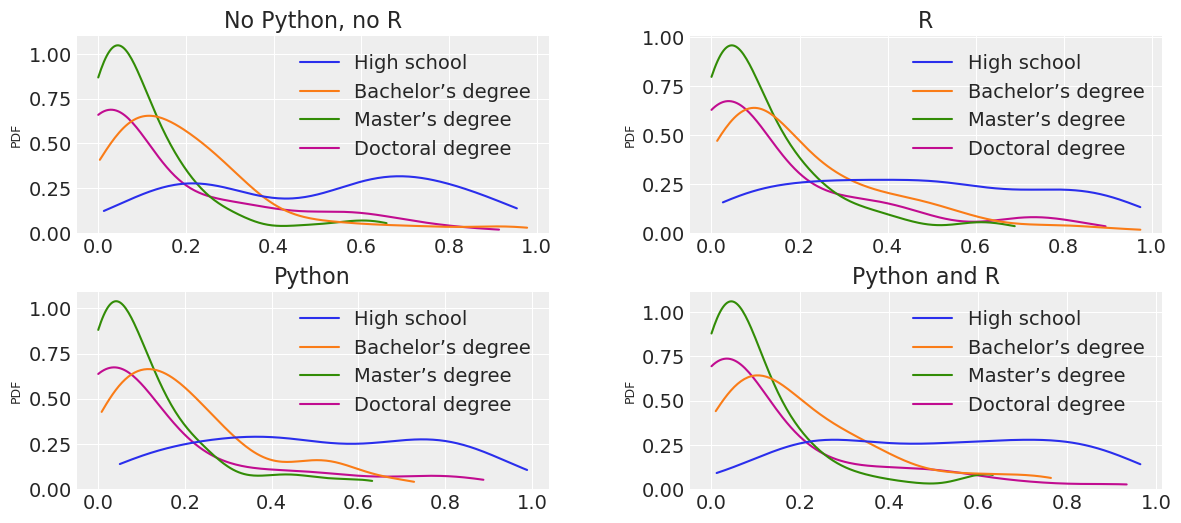

In [10]:
AxesNames = {
    0: "No Python, no R",
    1: "R",
    2: "Python",
    3: "Python and R",
}

# New Plotting:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
axes = axes.flatten()

for iid, ax in enumerate(axes):
    prior_probability_df = pd.DataFrame(prior_predictions['probs'].to_py()[:,iid,:],
                      columns=list(education_to_index.keys()))
    sns.kdeplot(data=prior_probability_df, ax=ax, cut=0)
    ax_name = AxesNames[iid]
    ax.set_title(ax_name)
    ax.set_ylabel('PDF', fontsize=9)
    
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# How to read each graph of the plot below:

    # According to the model's results, the likelihood of each interviewed person
    # (i.e., each sample from the dataframe) of having a given level of education (line colors)
    # provided that he/she knows "Neither Python nor R", "solely R",
    # "solely Python" or "Python and R" is most centered towards (a given value)
    
# For example, reading axes 0,0 - i.e., knows "neither Python, nor R":

    # High-school people are the solely ones that are more prone (likely) to know "neither Python or R".
    

# For example, reading axes 0,1 - i.e., knows "solely R":

    # Given that the interviewed person knows "solely R",
    # the most likely education level that he/she has will be any of the classes provided  
    # except for "High-School".
    # The "High-School" education level is the class less likely to be applied
    # in guessing one's education level based on he/she knowing "R".


## MCMC

In [24]:
sampler = numpyro.infer.NUTS(ordered_logistic_regression)
mcmc = numpyro.infer.MCMC(sampler,
                          num_chains=jax.local_device_count(), # in my case, I have 4 cores
                          num_samples=len(df)//100,
                          num_warmup=200)
mcmc.run(
    jax.random.PRNGKey(93),
    python=df["python"].to_numpy(),
    R=df["R"].to_numpy(),
    n_education_levels=4,
    education=df["education"].map(education_to_index).to_numpy(),
)

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

# Sumary: MCMC statistics:

- Obs: The higher the coefficient, the higher its importance for the analysis.

In [25]:
mcmc.print_summary()

# Red Flags to be aware of when applying your studies:

    # 1) N° of divergences > 0
    # 2) r_hat << 1


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
             coefficient_R      1.50      0.43      1.49      0.75      2.16    124.77      1.01
  coefficient_R_and_python      1.14      0.42      1.10      0.53      1.92    122.78      1.01
       coefficient_neither      0.42      0.43      0.41     -0.32      1.05    124.56      1.01
        coefficient_python      0.54      0.42      0.52     -0.21      1.17    122.48      1.01
              cutpoints[0]     -3.62      0.43     -3.65     -4.26     -2.86    127.84      1.01
              cutpoints[1]      0.32      0.42      0.30     -0.43      0.96    122.55      1.01
              cutpoints[2]      2.59      0.43      2.57      1.87      3.26    123.14      1.01

Number of divergences: 0


## Notice that the Programming Language "R" was the most important coefficient of the model

In [26]:
post_pred = numpyro.infer.Predictive(ordered_logistic_regression, mcmc.get_samples())
post_predictions = post_pred(
    jax.random.PRNGKey(93),
    python=np.array([0, 0, 1, 1]),
    R=np.array([0, 1, 0, 1]),
    n_education_levels=4,
)

# Visualizing the Posterior Probability Distribution of the Trained Model

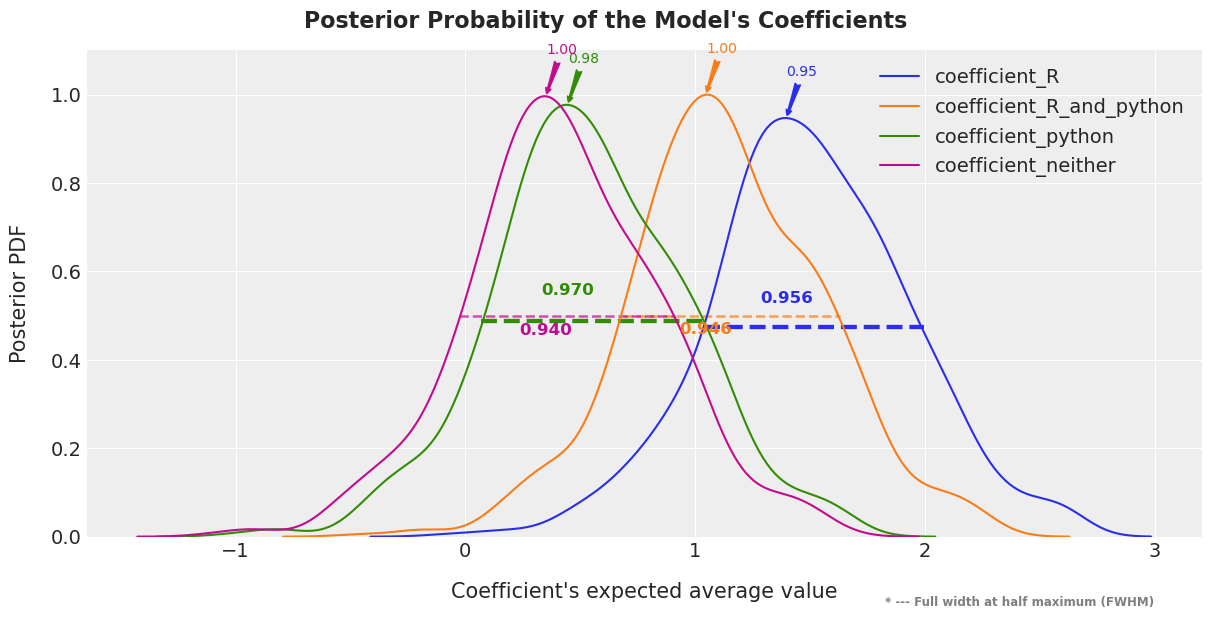

In [27]:
MCMC_Samples = mcmc.get_samples()

fig, ax = plt.subplots(figsize=(12, 6))
for coefficient in ['coefficient_R', 'coefficient_R_and_python',
                    'coefficient_python', 'coefficient_neither']:
    Coefficient_samples = MCMC_Samples[coefficient]
    sns.kdeplot(Coefficient_samples, ax=ax, label=coefficient)

for enum, kde_curve in enumerate(ax.lines):
    x = kde_curve.get_xdata()
    y = kde_curve.get_ydata()
    color = kde_curve.get_c()
    ymax = y.max()
    halfmax = y.max() / 2
    maxpos = y.argmax()
    leftpos = (np.abs(y[:maxpos] - halfmax)).argmin()
    rightpos = (np.abs(y[maxpos:] - halfmax)).argmin() + maxpos
    fullwidthathalfmax = x[rightpos] - x[leftpos]
    
    if enum%2:
        perct = 0.9
        width=1.8
        alpha=0.7
    else:
        perct = 1.1
        width=3.1
        alpha=1
    
    ax.hlines(halfmax, x[leftpos], x[rightpos], color=color, alpha=alpha, 
              linewidth=width, ls='--')
    
    ax.text(x[maxpos], halfmax*perct,
            f'{fullwidthathalfmax:.3f}\n',
            fontsize=12, fontweight='bold',
            color=color, ha='center', va='center')
    ax.set_ylim(ymin=0)
    
    xy_annotation = (x[maxpos], ymax)
    text = '{0:.2f}'.format(ymax)
    Annotation = ax.annotate(text,
                             xy_annotation,
                             xytext = (0.2, 30.5), 
                             xycoords=ax.transData,
                             textcoords = 'offset points', # Offset (in points) from the xy value
                             arrowprops=dict(arrowstyle = 'fancy',
                                            color=color),
                             color=color,
                             annotation_clip=True)

del Coefficient_samples
#

ax.legend()
ax.set_ylim(0,1.1)
ax.set_ylabel("Posterior PDF", labelpad=15)
ax.set_xlabel("Coefficient's expected average value", labelpad=15)
fig.text(0.845, 0.005,
        "* --- Full width at half maximum (FWHM)",
        fontsize=8.5, fontweight='bold',
        color='k', alpha=0.5, ha='center', va='center')

fig.suptitle("Posterior Probability of the Model's Coefficients", fontsize=16, fontweight='bold')

plt.show()

# notice that only the "R" is the only one coefficient whose curtosis (mass distribution) is more likely above zero;
# in another words, we can expect that more educated people tend to know "R" more likely than the other options


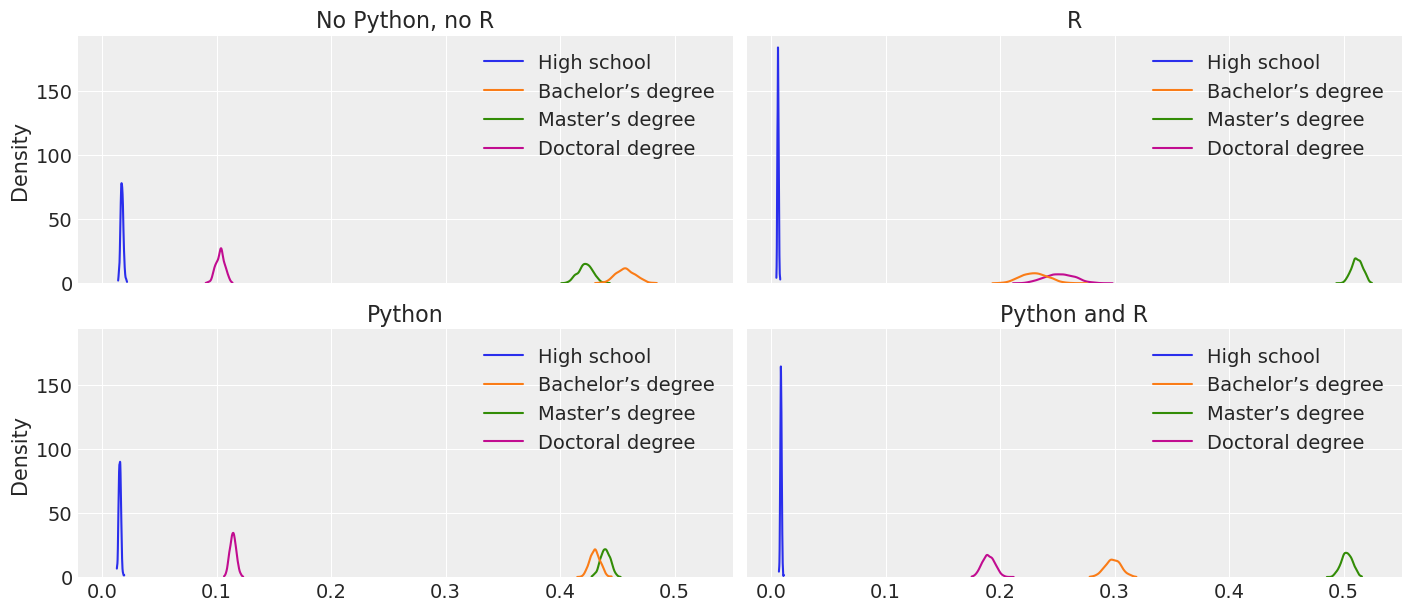

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True, sharey=True)
ax = ax.flatten()
rows = {
    0: "No Python, no R",
    1: "R",
    2: "Python",
    3: "Python and R",
}

for row, description in rows.items():
    prior_df = pd.DataFrame(
        post_predictions["probs"][:, row, :], columns=education_to_index
    )
    sns.kdeplot(data=prior_df, ax=ax[row], cut=0)
    ax[row].set_title(description)

## interpretation of the Graph above:


* Analysis of Axis 0,0:

Given that the interviewed person knows nothing of **Python** nor **R**, It is very unlikely that he/she has a High-School Degree. Meanwhile, it is more likely that this person has a Master's or a Bachelor's Degree (strange, but..., well, that is the interpretation we can do for now).

* Analysis of Axis 0,1:

Given that the interviewed person knows solely **R**, it is most likely that this person has a Master's degree, and less likely the other degree levels.

* Analysis of Axis 1,0:

Given that the interviewed person knows solely **Python**, it is most likely that this person has a Master's or a Bachelor's degree, and less likely the other degree levels.


* Analysis of Axis 1,1:

Given that the interviewed person knows both **Python** and **R**, it is most likely that this person has a Master's degree, and less likely the other degree levels.


## Conclusion

- We used the model above for evaluating the likelihood of an "ordered category problem" relating 
   a survey response based on programing language knowledge and one's educational level.
   
- In this Jupyter-Notebook, we implemented this model evaluation in NumPyro

- The results were strange, indicating that doctoral degree people are less likely to know programming language whatsoever. Probablyl, the survey has not been properly applied, or the yes/no answer may have not been so suited for our problem.
- Further approaches: evaluate the problem above for a survey response dataset with more range in one's answer; e.g.:
    Instead of Know Python, we could ask: "given a scale from 0 to 10, in which 0 represets no knowledge at all of **Python**, and 10, know a lot, what would you define yourself?"
    

## Resources

Statistical Rethinking - Richard McElreath

Betancourt's case studies and podcast

Learning Bayesian Statistics podcast - Alex Andorra

pymc-examples notebooks

## At Gousto - we're hiring!

https://www.gousto.co.uk/jobs